# Value Clustering for OP (Before Covid Effects)

In [2]:
# basic
import os
import numpy as np
import pandas as pd

# visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# Model
from scipy import stats
from sklearn.cluster import KMeans, DBSCAN, AffinityPropagation, Birch, MeanShift, AgglomerativeClustering
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score
from sklearn.ensemble import IsolationForest
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree

sns.set_style("whitegrid")
# sns.color_palette('bright')
# sns.set_palette('dark')

In [3]:
df = pd.read_excel('OP_Before_Covid_cleaned.xlsx')

In [4]:
df.head()

,Outlet Number,Name,Sub Trade Channel,Segment,Sales Center,Net Revenue
0,7517895,ELMAS CAY OCAGI-IHSAN ISLAMOGLU,TEA GARDEN,BRONZE,40: KARADENIZ SCM,100.02
1,8073460,HUSEYIN CAFE,TEA HOUSE,BRONZE,13: ISTANBUL COLD DRINK,100.02
2,8823876,CIZGI RESTORANT,TRADITIONAL RESTAURA,SILVER,50: BURSA SCM,100.02
3,8980364,MARMARIS BUFE,KIOSK/FOOD/CANTEEN,SILVER,13: ISTANBUL COLD DRINK,100.02
4,9014068,KARDESLER BUFE,KIOSK/FOOD/CANTEEN,BRONZE,13: ISTANBUL COLD DRINK,100.02


## EDA

In [5]:
# deleting white spaces
df.columns = df.columns.str.replace(' ', '')

In [6]:
df['OutletNumber'] = df['OutletNumber'].astype(object)

In [7]:
print("Total number of Outlets: ", df.OutletNumber.nunique())

Total number of Outlets:  171023


### Revenue Dist.

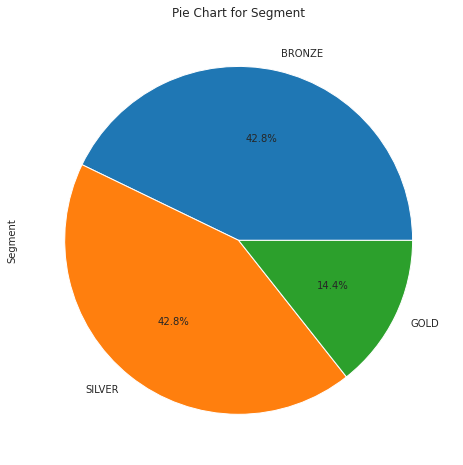

In [8]:
df['Segment'].value_counts().plot.pie(autopct='%1.1f%%', figsize=(8,8))
plt.title('Pie Chart for Segment')
plt.show()

In [9]:
df.Segment.value_counts()

BRONZE    73261
SILVER    73199
GOLD      24563
Name: Segment, dtype: int64

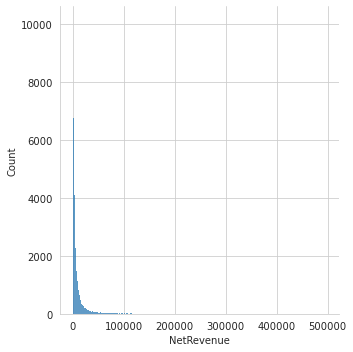

In [10]:
sns.displot(df['NetRevenue'])

In [11]:
df['log_rev'] = np.log(df['NetRevenue'])

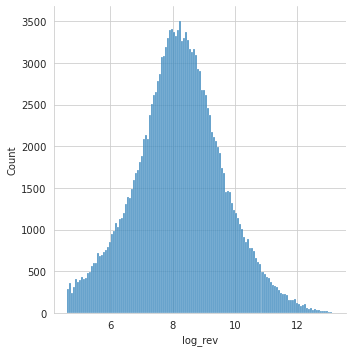

In [12]:
# after normalization
sns.displot(df['log_rev'])

## Optimal Cluster Number Analysis

In [13]:
rev_model_data = df['log_rev']

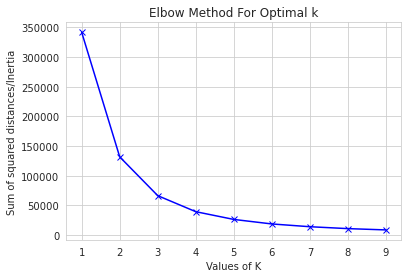

In [14]:
Sum_of_squared_distances = []
K = range(1,10)
for num_clusters in K :
    kmeans = KMeans(n_clusters=num_clusters, random_state=42)
    kmeans.fit(rev_model_data.values.reshape(-1, 1))
    Sum_of_squared_distances.append(kmeans.inertia_)
plt.plot(K,Sum_of_squared_distances,'bx-')
plt.xlabel('Values of K') 
plt.ylabel('Sum of squared distances/Inertia') 
plt.title('Elbow Method For Optimal k')
plt.show()

## Model

In [15]:
model = KMeans(n_clusters=4, random_state=42, max_iter=100000, init='random')

In [16]:
model.fit(rev_model_data.values.reshape(-1, 1))
preds = model.predict(rev_model_data.values.reshape(-1, 1))

In [17]:
rev_model_data = pd.concat([rev_model_data, pd.DataFrame({'preds':preds}, index=rev_model_data.index)], axis=1)

In [18]:
result = pd.merge(rev_model_data, df[['Segment', 'NetRevenue']], how='inner', left_index=True, right_index=True)
result['preds'] = result['preds'].astype('category')

In [19]:
result.head(1)

,log_rev,preds,Segment,NetRevenue
0,4.60537,3,BRONZE,100.02


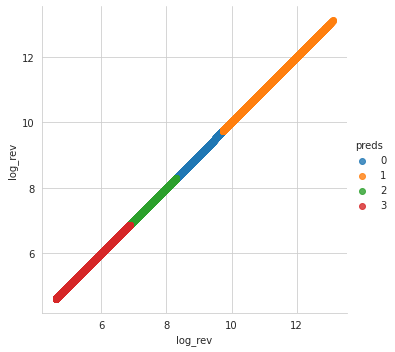

In [20]:
sns.lmplot(x='log_rev', y='log_rev', data=result, hue='preds', fit_reg=False)

In [21]:
result['rank'] = result['preds'].apply(lambda x: 
                                       0 if x==3 # red
                                       else 1 if x==2 # green
                                       else 2 if x==0 # blue
                                       else 3) # orange

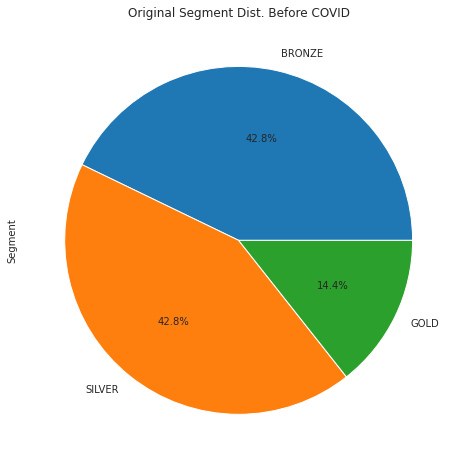

In [22]:
df["Segment"].value_counts().plot.pie(autopct='%1.1f%%', figsize=(8,8))
plt.title('Original Segment Dist. Before COVID')
plt.show()

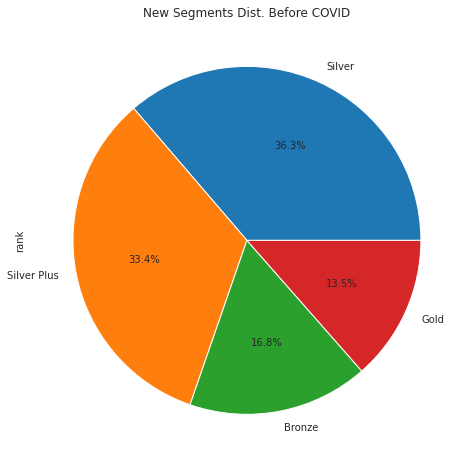

In [23]:
result["rank"].replace({0: "Bronze", 1: "Silver", 2: "Silver Plus", 3: "Gold"}).value_counts().plot.pie(autopct='%1.1f%%', figsize=(8,8))
plt.title('New Segments Dist. Before COVID')
plt.show()

In [24]:
result["rank"].replace({0: "Bronze", 1: "Silver", 2: "Silver Plus", 3: "Gold"}).value_counts()

Silver         62052
Silver Plus    57148
Bronze         28696
Gold           23127
Name: rank, dtype: int64

## Decision Points

In [25]:
d = DecisionTreeClassifier(random_state=42)
d.fit(result['NetRevenue'].values.reshape(-1,1), result['rank'])
d_preds = d.predict(result['NetRevenue'].values.reshape(-1,1))
d_text = tree.export_text(d)
print(d_text)

|--- feature_0 <= 4018.49
|   |--- feature_0 <= 967.93
|   |   |--- class: 0
|   |--- feature_0 >  967.93
|   |   |--- class: 1
|--- feature_0 >  4018.49
|   |--- feature_0 <= 16723.91
|   |   |--- class: 2
|   |--- feature_0 >  16723.91
|   |   |--- class: 3



In [26]:
result.NetRevenue.describe()

count    171023.000000
mean      10291.659724
std       24432.651409
min         100.020000
25%        1501.025000
50%        3641.110000
75%        8891.630000
max      498239.470000
Name: NetRevenue, dtype: float64

## Comparison Matrix

In [27]:
df_new = pd.merge(df[['OutletNumber','Name','SubTradeChannel','SalesCenter','NetRevenue','log_rev']], 
                  result[['Segment', 'rank']], 
                  how='inner', left_index=True, right_index=True)

rank         0      1      2      3
Segment                            
BRONZE   15528  45777  11872     84
GOLD       290    767   3817  19689
SILVER   12878  15508  41459   3354


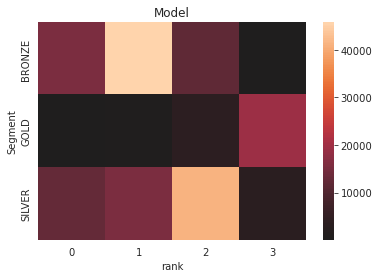

In [28]:
d1 = pd.pivot_table(data=df_new
              , index='Segment'
              , columns='rank'
              , values='OutletNumber'
              , aggfunc=np.size
              , fill_value=0).sort_index()

d1 = d1[sorted(d1.columns)]
print(d1)
sns.heatmap(d1, center=0).set_title('Model')
plt.show()

### Save as CSV

In [29]:
# final_df = df_new[['OutletNumber','Name','SubTradeChannel','SalesCenter','NetRevenue','rank']]

In [30]:
# ismi değiştir
# final_df.to_csv('results_clus4_20211005.csv', sep='|')

<h1><center>Regional Distribution</center></h1>

In [31]:
df.SalesCenter.unique()

array(['40: KARADENIZ SCM', '13: ISTANBUL COLD DRINK', '50: BURSA SCM',
       '60: MERSIN SCM', '90: IZMIR SCM', '20: ANTALYA SCM',
       '30: ANKARA SCM', '12: ISTANBUL HOME CHANNE', '70: ELAZIG SCM',
       '71: HOD', '65: AT WORK', '93: LAM HOTELS SCM'], dtype=object)

In [32]:
# WEST
df_w = df.loc[df['SalesCenter'].isin(['13: ISTANBUL COLD DRINK',
                                      '50: BURSA SCM',
                                      '90: IZMIR SCM',
                                      '30: ANKARA SCM',
                                      '71: HOD',
                                      '20: ANTALYA SCM',
                                      '93: LAM HOTELS SCM',
                                      '12: ISTANBUL HOME CHANNE'])]

In [33]:
df_w = df_w.reset_index(drop=True)

In [34]:
print("Total number of Outlets: ", df_w.OutletNumber.nunique())

Total number of Outlets:  114400


In [35]:
# EAST
df_e = df.loc[df['SalesCenter'].isin(['70: ELAZIG SCM','60: MERSIN SCM','40: KARADENIZ SCM','65: AT WORK'])]

In [36]:
df_e = df_e.reset_index(drop=True)

In [37]:
print("Total number of Outlets: ", df_e.OutletNumber.nunique())

Total number of Outlets:  56623


## West

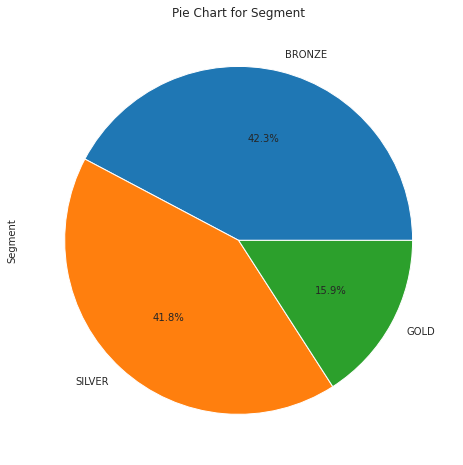

In [38]:
df_w['Segment'].value_counts().plot.pie(autopct='%1.1f%%', figsize=(8,8))
plt.title('Pie Chart for Segment')
plt.show()

In [39]:
df_w.Segment.value_counts()

BRONZE    48343
SILVER    47871
GOLD      18186
Name: Segment, dtype: int64

## Optimal Cluster Number Analysis

In [40]:
rev_data_w = df_w['log_rev']

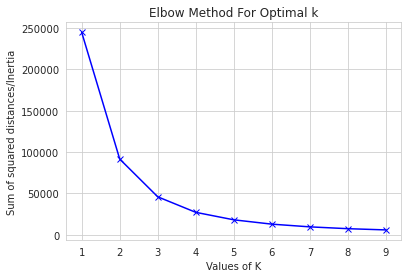

In [41]:
Sum_of_squared_distances = []
K = range(1,10)
for num_clusters in K :
    kmeans = KMeans(n_clusters=num_clusters, random_state=42)
    kmeans.fit(rev_data_w.values.reshape(-1, 1))
    Sum_of_squared_distances.append(kmeans.inertia_)
plt.plot(K,Sum_of_squared_distances,'bx-')
plt.xlabel('Values of K') 
plt.ylabel('Sum of squared distances/Inertia') 
plt.title('Elbow Method For Optimal k')
plt.show()

## Model

In [42]:
model_w = KMeans(n_clusters=4, random_state=42, max_iter=100000, init='random')

In [43]:
model_w.fit(rev_data_w.values.reshape(-1, 1))
preds_w = model_w.predict(rev_data_w.values.reshape(-1, 1))

In [44]:
rev_data_w = pd.concat([rev_data_w, pd.DataFrame({'preds':preds_w}, index=rev_data_w.index)], axis=1)

In [45]:
result_w = pd.merge(rev_data_w, df_w[['Segment', 'NetRevenue']], how='inner', left_index=True, right_index=True)
result_w['preds'] = result_w['preds'].astype('category')

In [46]:
result_w.head(1)

,log_rev,preds,Segment,NetRevenue
0,4.60537,0,BRONZE,100.02


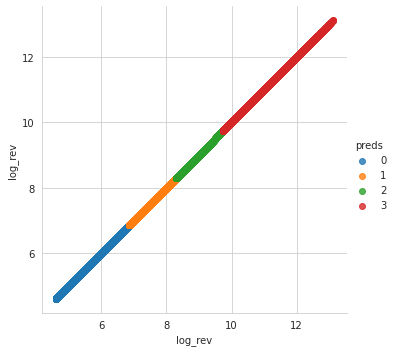

In [47]:
sns.lmplot(x='log_rev', y='log_rev', data=result_w, hue='preds', fit_reg=False)

In [48]:
result_w['rank'] = result_w['preds'].apply(lambda x: 
                                      0 if x==0 # blue
                                      else 1 if x==1 # orange
                                      else 2 if x==2 # green
                                      else 3) # red

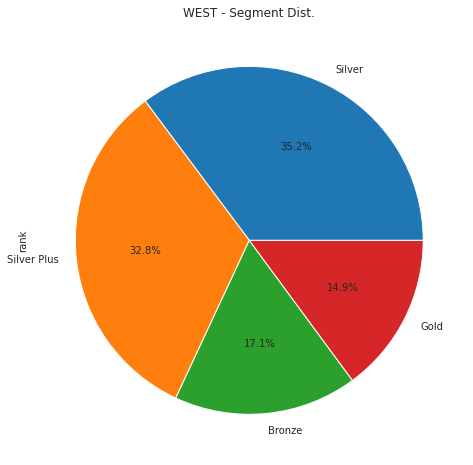

In [49]:
result_w["rank"].replace({0: "Bronze", 1: "Silver", 2: "Silver Plus", 3: "Gold"}).value_counts().plot.pie(autopct='%1.1f%%', figsize=(8,8))
plt.title('WEST - Segment Dist.')
plt.show()

In [50]:
result_w["rank"].replace({0: "Bronze", 1: "Silver", 2: "Silver Plus", 3: "Gold"}).value_counts()

Silver         40281
Silver Plus    37575
Bronze         19507
Gold           17037
Name: rank, dtype: int64

## Decision Points of WEST

In [51]:
d_w = DecisionTreeClassifier(random_state=42)
d_w.fit(result_w['NetRevenue'].values.reshape(-1,1), result_w['rank'])
d_preds_w = d_w.predict(result_w['NetRevenue'].values.reshape(-1,1))
d_text_w = tree.export_text(d_w)
print(d_text_w)

|--- feature_0 <= 4001.95
|   |--- feature_0 <= 948.30
|   |   |--- class: 0
|   |--- feature_0 >  948.30
|   |   |--- class: 1
|--- feature_0 >  4001.95
|   |--- feature_0 <= 17002.29
|   |   |--- class: 2
|   |--- feature_0 >  17002.29
|   |   |--- class: 3



## Comparison Matrix of WEST

In [52]:
df_new_w = pd.merge(df_w[['OutletNumber','Name','SubTradeChannel','SalesCenter','NetRevenue','log_rev']], 
                  result_w[['Segment', 'rank']], 
                  how='inner', left_index=True, right_index=True)

rank         0      1      2      3
Segment                            
BRONZE   10799  29829   7657     58
GOLD       188    536   2691  14771
SILVER    8520   9916  27227   2208


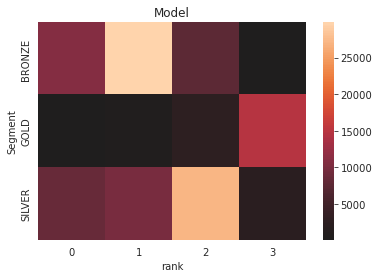

In [53]:
d1_w = pd.pivot_table(data=df_new_w
                    , index='Segment'
                    , columns='rank'
                    , values='OutletNumber'
                    , aggfunc=np.size
                    , fill_value=0).sort_index()

d1_w = d1_w[sorted(d1_w.columns)]
print(d1_w)
sns.heatmap(d1_w, center=0).set_title('Model')
plt.show()

## EAST

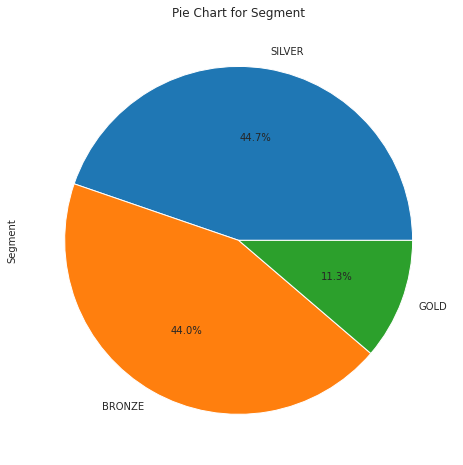

In [54]:
df_e['Segment'].value_counts().plot.pie(autopct='%1.1f%%', figsize=(8,8))
plt.title('Pie Chart for Segment')
plt.show()

In [55]:
df_e.Segment.value_counts()

SILVER    25328
BRONZE    24918
GOLD       6377
Name: Segment, dtype: int64

## Optimal Cluster Number Analysis

In [56]:
rev_data_e = df_e['log_rev']

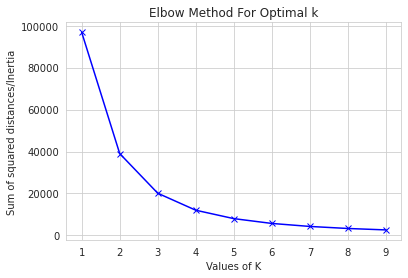

In [57]:
Sum_of_squared_distances = []
K = range(1,10)
for num_clusters in K :
    kmeans = KMeans(n_clusters=num_clusters, random_state=42)
    kmeans.fit(rev_data_e.values.reshape(-1, 1))
    Sum_of_squared_distances.append(kmeans.inertia_)
plt.plot(K,Sum_of_squared_distances,'bx-')
plt.xlabel('Values of K') 
plt.ylabel('Sum of squared distances/Inertia') 
plt.title('Elbow Method For Optimal k')
plt.show()

## Model

In [58]:
model_e = KMeans(n_clusters=4, random_state=42, max_iter=100000, init='random')

In [59]:
model_e.fit(rev_data_e.values.reshape(-1, 1))
preds_e = model_e.predict(rev_data_e.values.reshape(-1, 1))

In [60]:
rev_data_e = pd.concat([rev_data_e, pd.DataFrame({'preds':preds_e}, index=rev_data_e.index)], axis=1)

In [61]:
result_e = pd.merge(rev_data_e, df_e[['Segment', 'NetRevenue']], how='inner', left_index=True, right_index=True)
result_e['preds'] = result_e['preds'].astype('category')

In [62]:
result_e.head(1)

,log_rev,preds,Segment,NetRevenue
0,4.60537,3,BRONZE,100.02


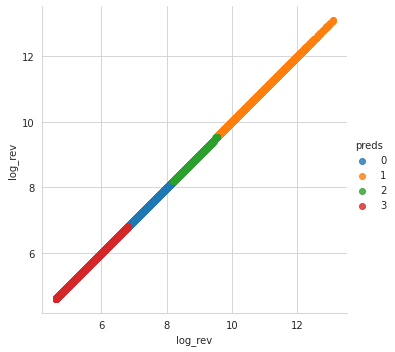

In [63]:
sns.lmplot(x='log_rev', y='log_rev', data=result_e, hue='preds', fit_reg=False)

In [64]:
result_e['rank'] = result_e['preds'].apply(lambda x: 
                                           0 if x==3 # red
                                           else 1 if x==0 # blue
                                           else 2 if x==2 # green
                                           else 3) # orange

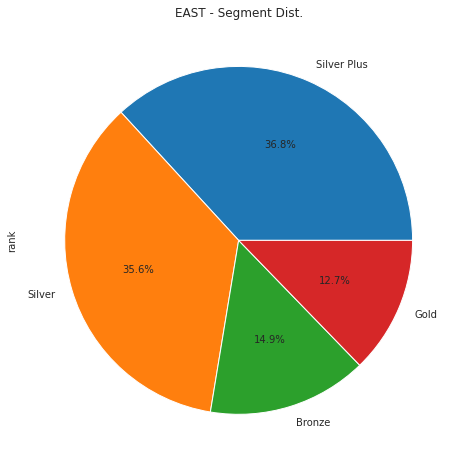

In [65]:
result_e["rank"].replace({0: "Bronze", 1: "Silver", 2: "Silver Plus", 3: "Gold"}).value_counts().plot.pie(autopct='%1.1f%%', figsize=(8,8))
plt.title('EAST - Segment Dist.')
plt.show()

In [66]:
result_e["rank"].replace({0: "Bronze", 1: "Silver", 2: "Silver Plus", 3: "Gold"}).value_counts()

Silver Plus    20850
Silver         20146
Bronze          8411
Gold            7216
Name: rank, dtype: int64

## Decision Points of EAST

In [67]:
d_e = DecisionTreeClassifier(random_state=42)
d_e.fit(result_e['NetRevenue'].values.reshape(-1,1), result_e['rank'])
d_preds_e = d_e.predict(result_e['NetRevenue'].values.reshape(-1,1))
d_text_e = tree.export_text(d_e)
print(d_text_e)

|--- feature_0 <= 3587.30
|   |--- feature_0 <= 922.66
|   |   |--- class: 0
|   |--- feature_0 >  922.66
|   |   |--- class: 1
|--- feature_0 >  3587.30
|   |--- feature_0 <= 13799.43
|   |   |--- class: 2
|   |--- feature_0 >  13799.43
|   |   |--- class: 3



## Comparison Matrix of EAST

In [68]:
df_new_e = pd.merge(df_e[['OutletNumber','Name','SubTradeChannel','SalesCenter','NetRevenue','log_rev']], 
                    result_e[['Segment', 'rank']], 
                    how='inner', left_index=True, right_index=True)

rank        0      1      2     3
Segment                          
BRONZE   4264  14684   5937    33
GOLD       89    203    918  5167
SILVER   4058   5259  13995  2016


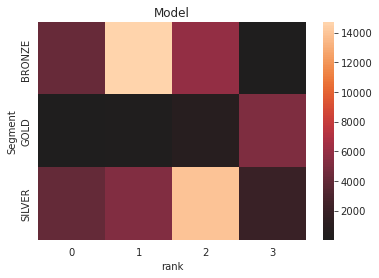

In [69]:
d1_e = pd.pivot_table(data=df_new_e
                    , index='Segment'
                    , columns='rank'
                    , values='OutletNumber'
                    , aggfunc=np.size
                    , fill_value=0).sort_index()

d1_e = d1_e[sorted(d1_e.columns)]
print(d1_e)
sns.heatmap(d1_e, center=0).set_title('Model')
plt.show()

<h1><center>Conclusion (Before Covid) </center></h1>

<img src="im0.png" width="800" align="center"/>

<img src="im1.png" width="800" align="center"/>

<img src="im2.png" width="800" align="center"/>

&nbsp;

<img src="im3.png" width="800" align="center"/>

In [70]:
# Türkiye gelenelinde bir clustering yapıldığında doğu ve batı bölgelerinin gold silver dağılımı nasıl?

## - BEFORE COVID - 

### How is the segment distribution in the "West" after clustering throughout Turkey?

In [73]:
# WEST
df_west = df_new.loc[df_new['SalesCenter'].isin(['13: ISTANBUL COLD DRINK',
                                                 '50: BURSA SCM',
                                                 '90: IZMIR SCM',
                                                 '30: ANKARA SCM',
                                                 '71: HOD',
                                                 '20: ANTALYA SCM',
                                                 '93: LAM HOTELS SCM',
                                                 '12: ISTANBUL HOME CHANNE'])]

rank         0      1      2      3
Segment                            
BRONZE   11021  29702   7559     61
GOLD       194    535   2578  14879
SILVER    8651   9819  27005   2396


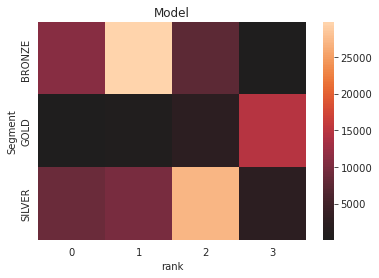

In [79]:
m1 = pd.pivot_table(data=df_west
                    , index='Segment'
                    , columns='rank'
                    , values='OutletNumber'
                    , aggfunc=np.size
                    , fill_value=0).sort_index()

m1 = m1[sorted(m1.columns)]
print(m1)
sns.heatmap(m1, center=0).set_title('Model')
plt.show()

### How is the segment distribution in the "East" after clustering throughout Turkey?

In [74]:
# EAST
df_east = df_new.loc[df_new['SalesCenter'].isin(['70: ELAZIG SCM','60: MERSIN SCM','40: KARADENIZ SCM','65: AT WORK'])]

rank        0      1      2     3
Segment                          
BRONZE   4507  16075   4313    23
GOLD       96    232   1239  4810
SILVER   4227   5689  14454   958


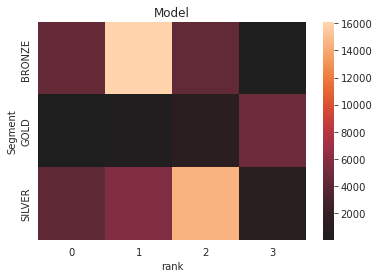

In [80]:
m2 = pd.pivot_table(data=df_east
                    , index='Segment'
                    , columns='rank'
                    , values='OutletNumber'
                    , aggfunc=np.size
                    , fill_value=0).sort_index()

m2 = m2[sorted(m2.columns)]
print(m2)
sns.heatmap(m2, center=0).set_title('Model')
plt.show()